In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from IPython.core.display_functions import display
from itertools import cycle

In [2]:
# read Dataset
df_name = ['Sample code number',
           'Clump Thickness',
           'Uniformity of Cell Size',
           'Uniformity of Cell Shape',
           'Marginal Adhesion',
           'Single Epithelial Cell Size',
           'Bare Nuclei',
           'Bland Chromatin',
           'Normal Nucleoli',
           'Mitoses',
           'Class:']
df_origin = pd.read_csv('dataset/breast-cancer-wisconsin.data', names=df_name)

In [3]:
# Data Exploration
# Check data information
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           699 non-null    int64 
 1   Clump Thickness              699 non-null    int64 
 2   Uniformity of Cell Size      699 non-null    int64 
 3   Uniformity of Cell Shape     699 non-null    int64 
 4   Marginal Adhesion            699 non-null    int64 
 5   Single Epithelial Cell Size  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Bland Chromatin              699 non-null    int64 
 8   Normal Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class:                       699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [4]:
# Statistics about data
df_origin.describe()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class:
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


<AxesSubplot:>

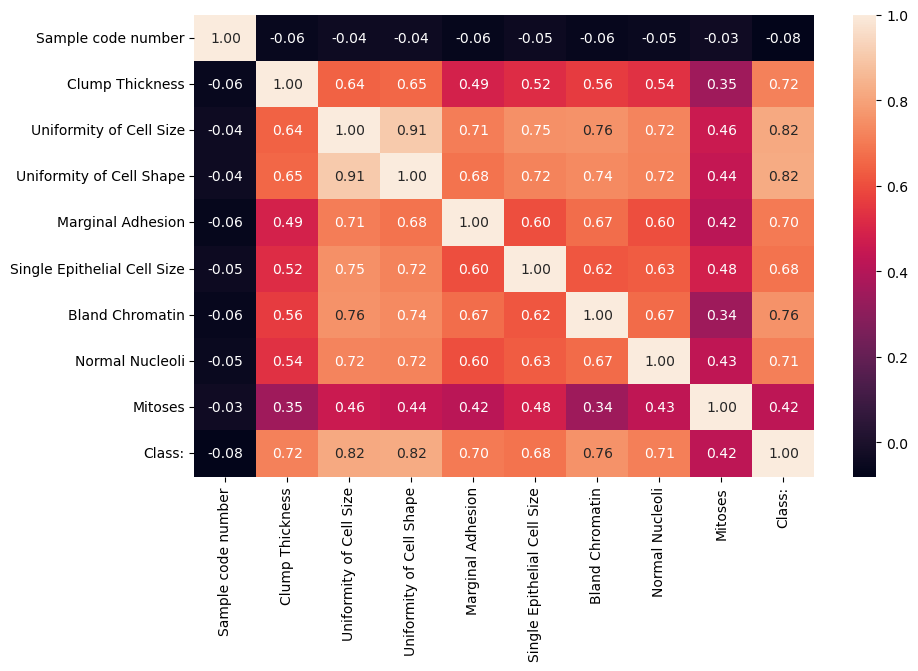

In [5]:
# Check the correlation of dataset between target and features
plt.figure(figsize=(10,6))
sns.heatmap(df_origin.corr(), annot=True, fmt='0.2f')

In [6]:
# Preprocessing
# Copy dataset
df = df_origin.copy()

# Replace '?' to NaN & Check missing data ('?') using NaN & Drop NaN data
df.replace('?', np.NAN, inplace=True)
df.dropna(inplace=True)

# Check

# Distinguish between what we need and what we don't
# X is feature class, Y is target class
x = df.iloc[:, 1:-1]  # 'sample code number' not need
y = df.iloc[:, -1]  # target is 'class'

In [7]:
# Single major function
def compare_classifications_model(data, target, models=None, scaler=None, encoders=None, param=None, k=None):
    # Default Classification models list
    if models is None:
        decision_tree_entropy = DecisionTreeClassifier(criterion='entropy')
        decision_tree_gini = DecisionTreeClassifier(criterion='gini')
        logistic_regress = LogisticRegression()
        support_vector = SVC()
        models = [decision_tree_entropy, decision_tree_gini, logistic_regress, support_vector]
        models_list = ['decision_tree_entropy', 'decision_tree_gini', 'logistic_regress', 'support_vector']
    else:
        models_list = models

    # Default scaler list
    if scaler is None:
        scaler = [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler(), Normalizer()]

    # Default encoders list
    if encoders is None:
        encoders = [False, LabelEncoder(), OrdinalEncoder()]

    # Default k-fold split list
    if k is None:
        k = [3, 5, 7, 10]

    # Each with multiple hyperparameter
    if param is None:
        param = {
            'decision_tree_entropy': {'max_depth': [None, 2, 3, 4],
                                      'min_samples_split': [2, 3, 4]},
            'decision_tree_gini': {'max_depth': [None, 2, 3, 4],
                                   'min_samples_split': [2, 3, 4]},
            'logistic_regress': {'C': [0.01, 0.1, 1, 10]},
            'support_vector': {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                               'C': [0.01, 0.1, 1],
                               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
        }

    # Create variables and data frames to store result
    df_columns = ['Model', 'Scaler', 'Encoder', 'k', 'Score', 'Parameter']
    best_score_models = pd.DataFrame({'Model': models_list}, columns=df_columns)
    best_score_models = best_score_models.fillna(0)
    all_models_data_list = []
    roc_curve_each_models = pd.DataFrame(index=range(0, len(models)),
                                         columns={'Model', 'fper', 'tper'})  # Store the Best each models of fper, tper

    for encoders_tmp in encoders:

        if encoders_tmp is not False:
            # Differentiate by dataset type
            data_category = data.select_dtypes(include='object')
            data_num = data.select_dtypes(exclude='object')

            # When the object is not in the dataset
            if encoders_tmp == LabelEncoder() and data_num.empty is False:
                encoders_tmp.fit(data_category)
                data_encode_num = encoders_tmp.transfrorm(data_num)
            elif encoders_tmp == OrdinalEncoder() and data_num.empty is False:
                encoders_tmp.fit(data_category)
                data_encode_num = encoders_tmp.transfrorm(data_num)
            else:
                data_encode_num = data_num

            # When the object is in the dataset
            if encoders_tmp == LabelEncoder() and data_category.empty is False:
                encoders_tmp.fit(data_category)
                data_encode_obj = encoders_tmp.transfrorm(data_category)
                data_encode = pd.concat([data_encode_num, data_encode_obj], axis=1)
            elif encoders_tmp == OrdinalEncoder() and data_category.empty is False:
                encoders_tmp.fit(data_category)
                data_encode_obj = encoders_tmp.transfrorm(data_category)
                data_encode = pd.concat([data_encode_num, data_encode_obj], axis=1)
            else:
                data_encode = data_encode_num
        else:
            data_encode = data

        # Training and test segmentation and shuffle
        x_train, x_test, y_train, y_test = train_test_split(data_encode, target, test_size=0.3,
                                                            shuffle=True, random_state=42)
        for i, models_tmp in enumerate(models):
            for scaler_tmp in scaler:
                for k_tmp in k:
                    # GridSearchCV of each model is used
                    grid_search = GridSearchCV(models_tmp, param_grid=dict(param[models_list[i]]), scoring="accuracy", cv=k_tmp)
                    grid_search.fit(x_train, y_train)
                    score = grid_search.best_score_

                    # Store results according to selected model, scalar, k, encoder
                    model_data = [models_list[i], scaler_tmp, encoders_tmp, k_tmp, score, grid_search.best_params_]

                    # Store the highest score among the selected model
                    if score > best_score_models.loc[i, 'Score'] or best_score_models.loc[i, 'Score'] == 0:
                        best_score_models.loc[i] = model_data
                        prob = grid_search.predict(x_test)
                        fprs, tprs, thresholds = roc_curve(y_test, prob, pos_label=4)
                        roc_curve_each_models.iloc[i, 0] = models_list[i]
                        roc_curve_each_models.iloc[i, 1] = fprs
                        roc_curve_each_models.iloc[i, 2] = tprs

                    # Add all results based on selected model, scalar, k, encoder
                    all_models_data_list.append(model_data)

    # Convert information in 'all_models_data_list' to data frames
    all_models_data = pd.DataFrame(all_models_data_list, columns=df_columns)

    # Plot ROC curve
    color_list = ["red", "orange", "aqua", "blue"]
    for j in range(0, len(models)):
        plt.plot(
            roc_curve_each_models.iloc[j, 1],
            roc_curve_each_models.iloc[j, 2],
            color=color_list[j],
            lw=1,
            label=roc_curve_each_models.iloc[j, 0]
        )

    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")

    # Returns the highest value for each model and the top 10 information in all cases
    return best_score_models, all_models_data.nlargest(10, 'Score'), plt

each_models_best


,Model,Scaler,Encoder,k,Score,Parameter
0,decision_tree_entropy,NaN,False,3,0.964479,"{'max_depth': 4, 'min_samples_split': 3}"
1,decision_tree_gini,Normalizer(),False,3,0.964452,"{'max_depth': 4, 'min_samples_split': 4}"
2,logistic_regress,None,False,5,0.970724,{'C': 0.01}
3,support_vector,None,False,3,0.972786,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}"


top10_best


,Model,Scaler,Encoder,k,Score,Parameter
72,support_vector,None,False,3,0.972786,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}"
76,support_vector,StandardScaler(),False,3,0.972786,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}"
80,support_vector,MinMaxScaler(),False,3,0.972786,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}"
84,support_vector,MaxAbsScaler(),False,3,0.972786,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}"
88,support_vector,RobustScaler(),False,3,0.972786,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}"
92,support_vector,Normalizer(),False,3,0.972786,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}"
75,support_vector,None,False,10,0.972739,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"
79,support_vector,StandardScaler(),False,10,0.972739,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"
83,support_vector,MinMaxScaler(),False,10,0.972739,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"
87,support_vector,MaxAbsScaler(),False,10,0.972739,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"


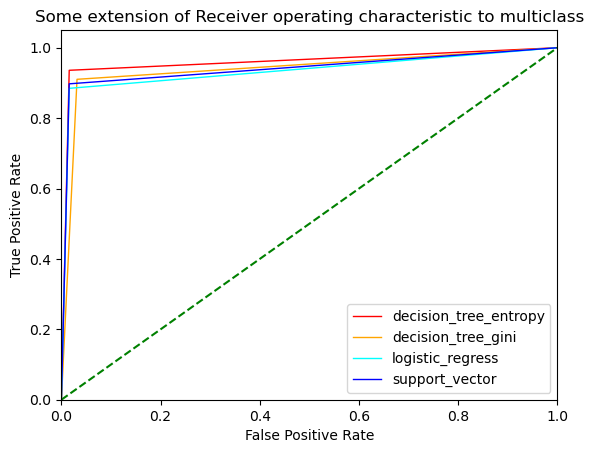

In [8]:
# Main
# Adjusting for Data Frame Output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

each_models_best, top10_best, graph = compare_classifications_model(x, y)

print('each_models_best')
display(each_models_best)
print('top10_best')
display(top10_best)
graph.show()